The following tutorial reproduces the results of Tutorial 3 on spinw.org. It is a frustrated J1-J2 AFM chain. Since it is an incommensurate structure, single Q method has been used to obtain the results. 

Get Packages

In [1]:
using Sunny, Revise,LinearAlgebra,CairoMakie,GLMakie
using Optim, Optimization, OptimizationOptimJL
includet("DispersionAndIntensitiesDipoleSingleQ.jl")
includet("SWTSingleQcalculations.jl")

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. Cu+ ions have spin=1 and are located at the origin of the unit cell. 

In [2]:
a = 3
b = 8
c = 10
latvecs = lattice_vectors(a,b,c,90,90,90)
positions = [[0,0,0]]
types = ["A"]
cryst = Crystal(latvecs,positions;types)
view_crystal(cryst)
sys = System(cryst,(1,1,1),[SpinInfo(1,S=1,g=2)], :dipole,seed =0)

System [Dipole mode]
Lattice (1×1×1)×1
Energy per site 0


Set up the exchanges to obtain the Hamiltonian. The nearest neighbour neighbour exchange is ferromagnetic, but the second nearest neighbour exchange is antiferromagntic thus leading to frustration in the system.

In [3]:
J1 = -1
J2 = 2
set_exchange!(sys,J1,Bond(1, 1, [1, 0, 0]))
set_exchange!(sys,J2,Bond(1, 1, [2, 0, 0]))

The system is incommensurate and so creating a supercell wouldn't work here directly. Single Q calculations method has been used instead. An axis of rotation is specified. The spins are randomized, a range for parameters and an initial guess for those parameters is provided,and then optimization is performed to obtain the (kx,ky,kz) values. 

In [11]:

n = [0.,0,1]

#Sunny.check_rotational_symmetry(sys; n, θ=0.01)

# Now we need to find the magnetic ground state. optimagstr function helps us to 
# find the ground state and the propagation vector for that ground state.
# It uses a constraint function (@gm_planar in this case) to reduce the number of paramteres that has to be optimised. 
# It works well if the number of free parameters are low. we will find that the right k-vector is [1/3,1/3,0].

randomize_spins!(sys)
#       Phi1   Phi2  Phi3  k_x  k_y   k_z
xmin = [-1e-6 -1e-6 -1e-6 -1e-6] # Minimum value of x
xmax = [2π 0.5 1e-6 1e-6]  # Maximum value of x
x0 = [0.8 0.25 0.0 0.0]  # Initial value of x

#k = optimagstr(x->gm_planar!(sys,n,x),xmin,xmax,x0)
k = Sunny.optimize_luttinger_tisza_exchange(sys)
Sunny.minimize_energy_spiral!(sys, k, n)

-2.0625000000000004

Perform Linear Spin Wave Theory calculations on the system. Create a spinw object, set up a path and calculate the dispersion bands and their intensity. Note that different functions have been used here to obtain dispersion and intensity as the functions previously used in the supercell method wouldn't work in the single Q case.

In [12]:
qs = [[0,0,0.],[1.0,0.,0]]
density = 250
path, xticks = reciprocal_space_path(cryst, qs, density)
swt = SpinWaveTheory(sys)
formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = Sunny.intensities_bands_SingleQ(swt, path, formula);

Plot the Spin wave dispersion. There are three modes. The shifted ones are due to the incommensurate structure.

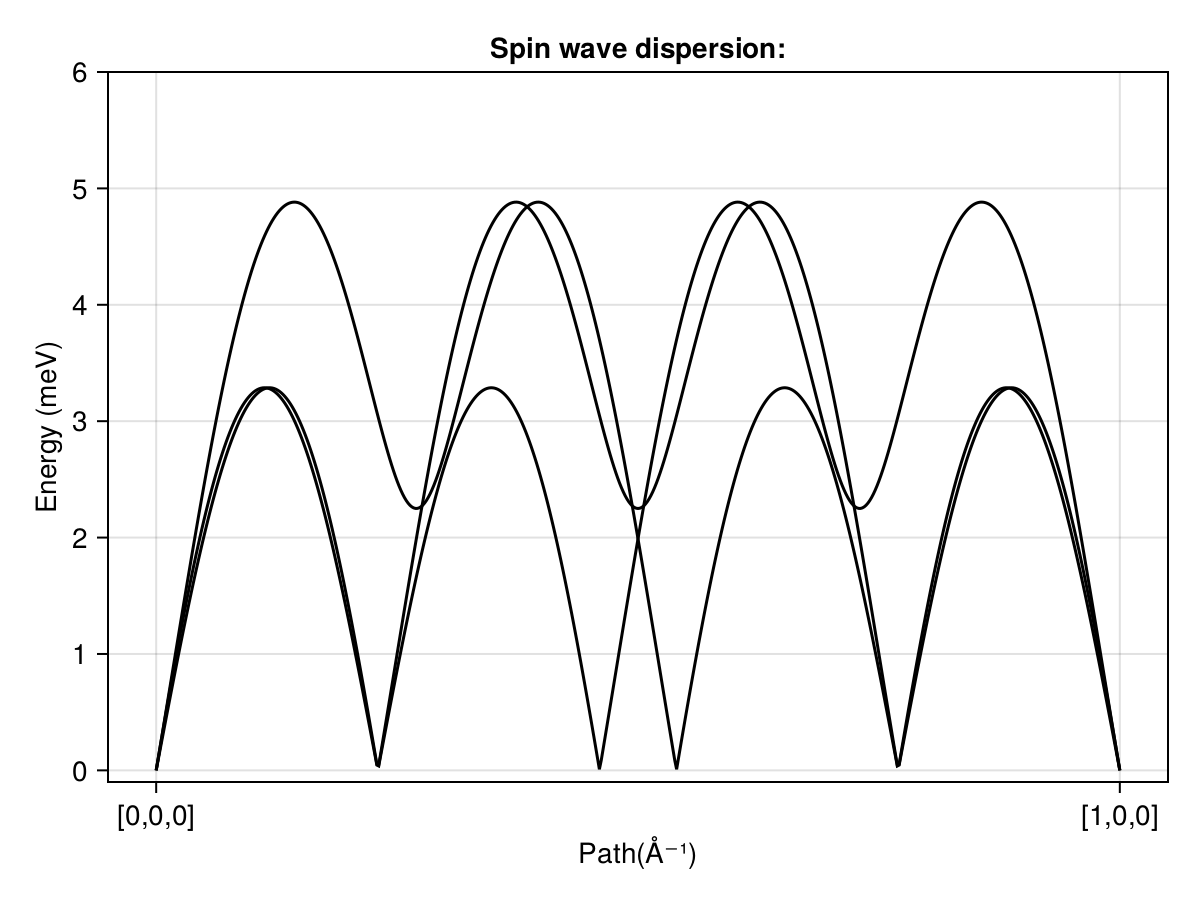

In [13]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Path(Å⁻¹)", ylabel="Energy (meV)",title="Spin wave dispersion:", xticks)
ylims!(ax, -1e-1, 6)
for i in axes(disp, 2)
    lines!(ax, 1:length(disp[:,i]), disp[:,i];color="black",colorrange=(0,1e-2))
end
fig